# Trajectory analysis benchmark

***

Jan T. Schleicher, 2024

Here, we use Monocle3 ([Trapnell et al. 2014](https://doi.org/10.1038/nbt.2859), [Qiu et al. 2017](https://doi.org/10.1038/nmeth.4402), [Cao et al. 2019](https://doi.org/10.1038/s41586-019-0969-x)) and Slingshot ([Street et al. 2018](https://doi.org/10.1186/s12864-018-4772-0)) to analyze differentiation trajectories of exhausted CD8 T cells.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import scvelo as scv
from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append("../utils/")
from run_slingshot import run_slingshot
from run_monocle3 import run_monocle3

import rpy2.robjects as robjects

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import rpy2.robjects.pandas2ri
rpy2.robjects.pandas2ri.activate()


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [2]:
adata = sc.read_h5ad("../data/tex_data_chronic_annotated.h5ad")

## Monocle3

In [3]:
monocle_pst, monocle_graph_coordinates, monocle_graph = run_monocle3(
    adata=adata, root_clusters="5", cluster_key="leiden"
)

R[write to console]: X -> counts



  |======================================================================| 100%


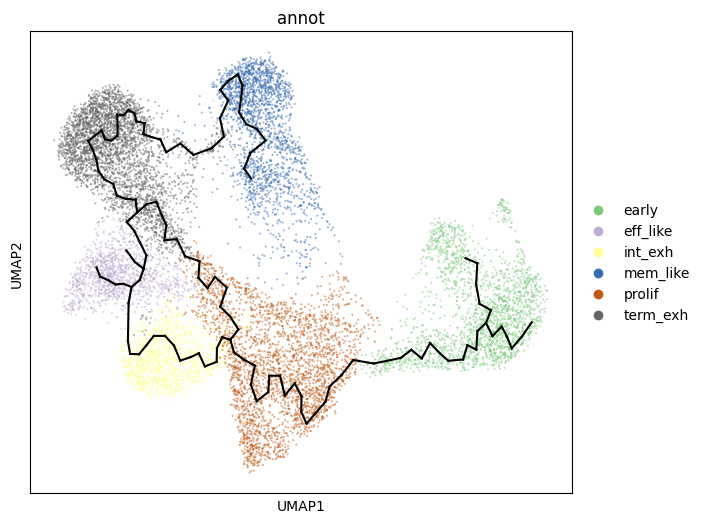

In [4]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(adata, color="annot", ax=ax, alpha=.5, show=False)
for source, target in zip(monocle_graph[2], monocle_graph[3]):
    ax.plot(monocle_graph_coordinates.iloc[[source, target], 0],
            monocle_graph_coordinates.iloc[[source, target], 1], color="k")

In [5]:
monocle_edgelist = pd.DataFrame(data=np.stack([monocle_graph[2], monocle_graph[3]]).T,
                                columns=["source", "target"], dtype=int)

In [6]:
# Export monocle results
monocle_pst.to_csv("../output/monocle_pst.csv")
monocle_graph_coordinates.to_csv("../output/monocle_graph_coordinates.csv")
monocle_edgelist.to_csv("../output/monocle_graph.csv")

## Slingshot

In [7]:
slingshot_pst_data, slingshot_alignment_data, slingshot_curves = run_slingshot(
    adata=adata, terminal_states=["0", "3"], root_states=["5"], cluster_key="leiden"
)

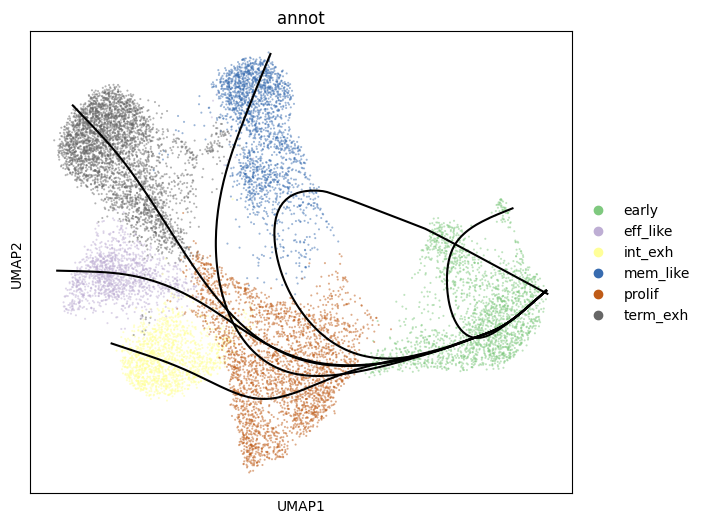

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(adata, color="annot", ax=ax, show=False, alpha=.5)
for arr in slingshot_curves:
    ax.plot(arr[:, 0], arr[:, 1], color="k")

In [9]:
# Export slingshot results
slingshot_pst = slingshot_pst_data.mean(axis=1).to_frame(name="Pseudotime")
slingshot_pst.to_csv("../output/slingshot_pst.csv")
np.save("../output/slingshot_curves.npy", slingshot_curves)

## Plotting with pseudotime

In [10]:
adata.obs["monocle_pseudotime"] = monocle_pst.Pseudotime.values
adata.obs["slingshot_pseudotime"] = slingshot_pst_data.mean(axis=1).values

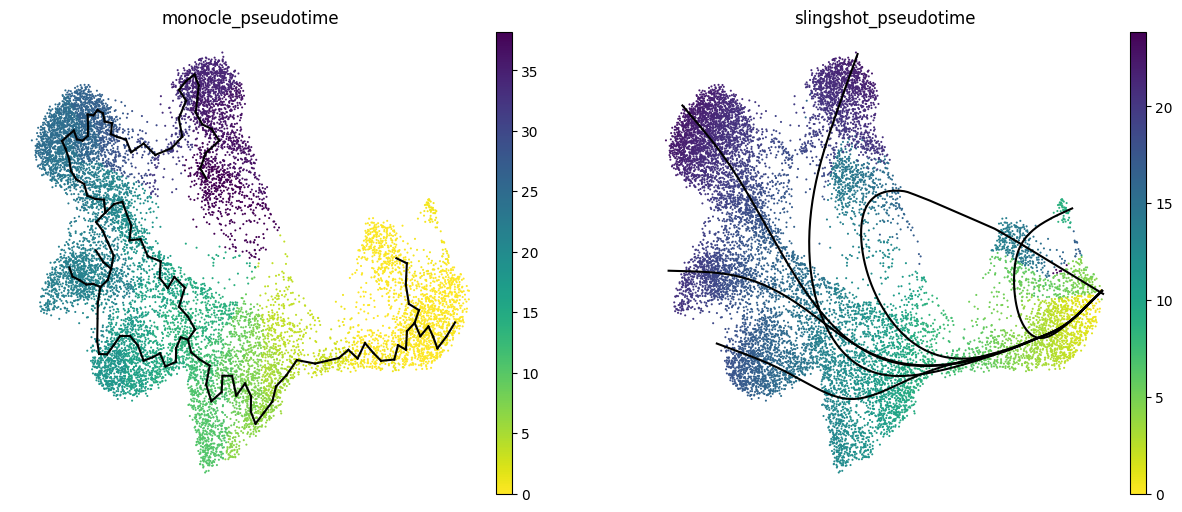

In [12]:
fix, axs = plt.subplots(ncols=2, figsize=(15, 6))

# Plot Monocle3 pseudotime and trajectories
sc.pl.umap(adata, color="monocle_pseudotime", ax=axs[0], show=False, cmap="viridis_r", frameon=False)
for source, target in zip(monocle_graph[2], monocle_graph[3]):
    axs[0].plot(monocle_graph_coordinates.iloc[[source, target], 0],
                monocle_graph_coordinates.iloc[[source, target], 1], color="k")

# Plot Slingshot pseudotime and trajectories
sc.pl.umap(adata, color="slingshot_pseudotime", ax=axs[1], show=False, cmap="viridis_r", frameon=False)
for arr in slingshot_curves:
    axs[1].plot(arr[:, 0], arr[:, 1], color="k")
fig.tight_layout();